# Simultion of adhesion cluster in the horizontal model

## 0. Setting up

#### Imports

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import random
import math
from scipy import special
import bisect
from statistics import mean
import time
import concurrent.futures
from cycler import cycler
import pickle
import os 

#### Parameters

In [2]:
kappab = 0.25
k_BT = 4.114 # k_B T at room temperature (298K) in units of pN*nm = 10^{-21}Nm
l_b = 1 # rest length in units of nm
e_b = 1.5 # binding energy in units of k_BT 
sigma_b = math.sqrt(k_BT / 0.25) #not sure about kappa_b = 0.25, please refer to Supplementary Notes I. Parameters 
Delta = 10 # in units of nm, Delta = Delta1 + Delta2
e_f = 0.5 # unfolding energy in units of k_BT 
k_beta = 1
k_delta = 1
F0 = k_BT/ math.sqrt(k_BT )

## 1. Functions

#### Probability distribution

In [3]:
def bind_p(x):
    return k_beta/(np.sqrt(2*math.pi)*sigma_b)*np.exp(-(abs(x)-l_b)**2/(2*sigma_b**2) + e_b)
def bind_p_u(x):
    return k_beta/(np.sqrt(2*math.pi)*sigma_b)*np.exp(-(abs(x-Delta)-l_b)**2/(2*sigma_b**2) + e_b)

resolution = 10_000
h = [n/resolution for n in range(-25*resolution,40*resolution)]

prob_bind = list(map(bind_p, h))
prob_bind_u = list(map(bind_p_u, h))

#### Choose random stretch according to prob. distribution

In [4]:
def random_stretch():
    return random.choices(h, prob_bind)[-1]
def random_stretch_u():
    return random.choices(h, prob_bind_u)[-1]

#### Initialize system of molecules

In [5]:
def system_init():
    system = [[],[]]
    for i in range(0, na_init):
        system[0].append(0)
        system[1].append(0)
    for i in range(0, nb_init):
        system[0].append(1)
        system[1].append(0)
    for i in range(0, nau_init):
        system[0].append(2) 
        system[1].append(0)
    for i in range(0, nbu_init):
        system[0].append(3)
        system[1].append(0)
    return system

#### Initial shift due to external force (if force = 0, s0 = 0) and stretch of each molecule

In [6]:
def stretch_mol_init(f, system, s):
    s.append(f*F0/(kappab * (system[0].count(1) + system[0].count(3))))
    for i in range(0, len(system[1][:])):
        state = system[0][i]
        if state == 0 or state == 2:
            system[1][i] = 0
        elif state == 1 or state == 3: 
            system[1][i] = s[-1]
    return system, s

#### Define rates 

In [7]:
def betap(): #reaction 0
    return k_beta * np.exp(e_b)*(1 + math.erf(l_b/(sigma_b * math.sqrt(2))))  
def betam(stretch): #reaction 1
    return k_beta * np.exp((2 * abs(stretch) * l_b - l_b**2) / (2*sigma_b**2)) 
def betapu(): #reaction 2 
    return k_beta * np.exp(e_b)*(1 + math.erf(l_b/(sigma_b * math.sqrt(2))))
def betamu(stretch): #reaction 3
    return k_beta * np.exp((2 * abs(stretch) * l_b - l_b**2) / (2*sigma_b**2)) 
def deltaap(): #reaction 4
    return k_delta * np.exp(-1*e_f)
def deltabp(stretch): #reaction 5
    return k_delta * np.exp((2 * (Delta - Delta/2) * (stretch) - (Delta - Delta/2)**2) / (2*sigma_b**2) - e_f)
def deltaam(): #reaction 6
    return k_delta
def deltabm(stretch): #reaction 7
    return k_delta * np.exp((-2 * (Delta - Delta/2) * (stretch) - (Delta - Delta/2)**2) / (2*sigma_b**2))
def gammap(Nbu, xi): #reaction 8
    return gammap_0 + xi * Nbu
def gammam(): #reaction 9
    return gammamin

#### Assign propensities

In [8]:
def propensities(system, xi , Nbu):
    prop = [[],[0],[],[]] # [[reaction id],[cumulative rate], [place in list system], [new state it would become after reaction]]
    for i in range(0, len(system[0])):
        state = system[0][i]
        
        if state == 0:               
            prop[0].append(0)
            prop[1].append(prop[1][-1] + betap()) # a -> b
            prop[2].append(i)
            prop[3].append(1)

            prop[0].append(4)
            prop[1].append(prop[1][-1] + deltaap()) # a -> au
            prop[2].append(i)
            prop[3].append(2)

            prop[0].append(9)
            prop[1].append(prop[1][-1] + gammam()) # a -> res
            prop[2].append(i)
            prop[3].append(-1)
            
            continue

        elif state == 1:
            prop[0].append(1)
            prop[1].append(prop[1][-1] + betam(system[1][i])) #b -> a 
            prop[2].append(i)
            prop[3].append(0)

            prop[0].append(5)
            prop[1].append(prop[1][-1] + deltabp(system[1][i])) #b -> bu
            prop[2].append(i)
            prop[3].append(3)  
            
            continue

        elif state == 2:
            prop[0].append(2)
            prop[1].append(prop[1][-1] + betapu()) # au -> bu
            prop[2].append(i)
            prop[3].append(3)

            prop[0].append(6)
            prop[1].append(prop[1][-1] + deltaam()) #au -> a
            prop[2].append(i)
            prop[3].append(0)
            
            continue

        elif state == 3:
            prop[0].append(3)
            prop[1].append(prop[1][-1] + betamu(system[1][i])) # bu -> au
            prop[2].append(i)
            prop[3].append(2)

            prop[0].append(7)
            prop[1].append(prop[1][-1] + deltabm(system[1][i])) #bu -> b
            prop[2].append(i)
            prop[3].append(1)
            
            continue
        
    prop[0].append(8)
    prop[1].append(prop[1][-1] + gammap(Nbu, xi)*nres)
    prop[2].append(-1)
    prop[3].append(0)

    prop[1].pop(0)
    
    return prop

#### Select reaction

In [9]:
def choose_reaction(prop, var): 
    rand_reaction = var * prop[1][-1]
    return bisect.bisect_left(prop[1], rand_reaction)

#### Update molecule state and stretch according to reaction

In [10]:
def system_update_reaction(x, s, system, prop):
    oldstate = system[0][prop[2][x]]
    
    if prop[0][x] == 0: # betap(): a->b
        system[0][prop[2][x]] = 1 
        system[1][prop[2][x]] = random_stretch()
    
    elif prop[0][x] == 1: # betam(): b->a
        system[0][prop[2][x]] = 0 
        system[1][prop[2][x]] = 0
    
    elif prop[0][x] == 2: # betapu(): au->bu
        system[0][prop[2][x]] = 3 
        system[1][prop[2][x]] = random_stretch()
        
    elif prop[0][x] == 3: # betamu(): bu->au
        system[0][prop[2][x]] = 2 
        system[1][prop[2][x]] = 0
        
    elif prop[0][x] == 4: # deltaap(): a->au
        system[0][prop[2][x]] = 2 
        system[1][prop[2][x]] = 0
        
    elif prop[0][x] == 5: # deltabp(): b->bu
        system[0][prop[2][x]] = 3 
        system[1][prop[2][x]] = system[1][prop[2][x]] - Delta
    
    elif prop[0][x] == 6: # deltaam(): au->a
        system[0][prop[2][x]] = 0 
        system[1][prop[2][x]] = 0 
        
    elif prop[0][x] == 7: # deltabm(): bu->b
        system[0][prop[2][x]] = 1 
        system[1][prop[2][x]] = system[1][prop[2][x]] + Delta

    elif prop[0][x] == 8: #reaction id = 8, i.e., gamma plus -> new state is created
        system[0].append(0) #new state created with molecule = a 
        system[1].append(0) #thus, stretch = 0
    
    elif prop[0][x] == 9: #reaction id = 9, i.e., gamma minus -> current state is removed
        system[0].pop(prop[2][x]) #current state is removed
        system[1].pop(prop[2][x]) #corresponding stretch gets also removed
   
    else:
        print(f'ERROR! State after: {prop[3][x]}, state before: {system[0][prop[2][x]] }')
        
    return system

#### Update the surface's shift (which depends on the number of bonds)

In [11]:
def stretch_tot(s, system, f):
    sum_eq_shift = 0
    if (system[0].count(1) + system[0].count(3)) > 0:
        
        for i in range(0, len(system[1])):
            if system[0][i] == 1 or system[0][i] == 3:
                sum_eq_shift += s[-1] - system[1][i] 
        
        s.append(1/(system[0].count(1) + system[0].count(3))*(f*F0/kappab + sum_eq_shift))
        return s
    else:
        print(f'Complete dissociation at xi = {xi} and f = {f}')
        return 0

#### Update molecules stretch according to new shift

In [12]:
def stretch_mol_update(s, system):
    for i in range(0, len(system[1][:])):
        state = system[0][i]
        if state == 0 or state == 2:
            system[1][i] = 0
        elif state == 1 or state == 3: 
            system[1][i] = s[-1] - (s[-2] - system[1][i])
    return system

## 2. Main Function - Gillespie Algrithm

In [23]:
def HorizontalModel_xi(x):
    xi = x
    print(xi)

    occupation_all = []
    time_all = []
    shift = []

    for force in forces:
        s = [0]
        t = [0]

        # initialize system
        system = system_init()
        occupation = [[system[0].count(0)],[system[0].count(1)],[system[0].count(2)],[system[0].count(3)]]

        system , s = stretch_mol_init(force, system, s)        
        
        ## Gillespie
        for i in range(0, noreact):
            Nbu = system[0].count(3)
            
            prop = propensities(system, xi, Nbu)
            var = random.random()
            tau = - np.log(1 - var)/(prop[1][-1])
            t.append(t[-1] + tau)

            k = choose_reaction(prop, var)
            system = system_update_reaction(k ,s, system, prop)
            #new_stretch
            s = stretch_tot(s, system, force)
            if s == 0:
                break

            ##update molecule stretches
            system = stretch_mol_update(s, system)
            
            occupation[0].append(system[0].count(0))
            occupation[1].append(system[0].count(1))
            occupation[2].append(system[0].count(2)) 
            occupation[3].append(system[0].count(3))

            if system[0].count(1) + system[0].count(3) == 0:      
                print(f'Complete dissociation at xi = {xi} and f = {force}')
                break
        
        occupation_all.append(occupation)
        time_all.append(t)
        shift.append(s)

    return occupation_all, time_all, shift

## 3. Set initial conditons

In [26]:
gammap_0 = 10  
gammamin = 1

na_init = 100
nb_init = 60 
nau_init = 20
nbu_init = 10

nres = 1

noreact = 1_000

forces = [i for i in range(0, 13, 4)]
lst = [0, 0.1, 0.2, 0.3]

## 4. Run Simulation

In [27]:
start = time.perf_counter()

with concurrent.futures.ProcessPoolExecutor() as executor: # LRZ Cluster insert max_workers=int(os.environ['SLURM_CPUS_PER_TASK'])
    results = executor.map(HorizontalModel_xi, lst)
    i = 0
    dict = {}

    for result in results:
        for t in forces:
            dict[f'xi{lst[i]}_f{t}_occ'] = result[0][forces.index(t)]
            dict[f'xi{lst[i]}_f{t}_time'] = result[1][forces.index(t)]
            dict[f'xi{lst[i]}_f{t}_shift'] = result[2][forces.index(t)]
        i += 1

#with open(f'Transition_xi{lst[0]}-{lst[-1]}_gp{gammap_0}_gm{gammamin}_f{forces[0]}-{forces[-1]}_molinit{na_init}-{nb_init}-{nau_init}-{nbu_init}_noreac{noreact}_tsteady{tsteadystate}.pkl', 'wb') as f:
    #pickle.dump(dict, f)

finish = time.perf_counter()
print(f'Finished in {round(finish - start, 2)/60} minutes')   


00.3

0.10.2

Finished in 0.9996666666666666 minutes


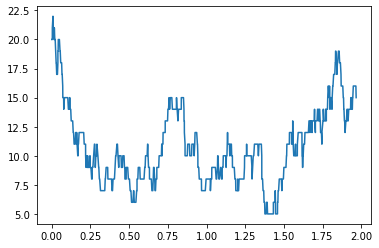

In [33]:
xi = 0.1
f = 12
plt.plot(dict.get(f'xi{xi}_f{f}_time'), dict.get(f'xi{xi}_f{f}_occ')[2])
plt.show()